In [26]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/aptos2019-blindness-detection/sample_submission.csv
/kaggle/input/aptos2019-blindness-detection/train.csv
/kaggle/input/aptos2019-blindness-detection/test.csv
/kaggle/input/aptos2019-blindness-detection/train_images/ef476be214d4.png
/kaggle/input/aptos2019-blindness-detection/train_images/6dcde47060f9.png
/kaggle/input/aptos2019-blindness-detection/train_images/ec363f48867b.png
/kaggle/input/aptos2019-blindness-detection/train_images/17f6c7072f61.png
/kaggle/input/aptos2019-blindness-detection/train_images/b49b2fac2514.png
/kaggle/input/aptos2019-blindness-detection/train_images/af6166d57f13.png
/kaggle/input/aptos2019-blindness-detection/train_images/8d13c46e7d75.png
/kaggle/input/aptos2019-blindness-detection/train_images/c3b15bf9b4bc.png
/kaggle/input/aptos2019-blindness-detection/train_images/be68322c7223.png
/kaggle/input/aptos2019-blindness-detection/train_images/88e4399d207c.png
/kaggle/input/aptos2019-blindness-detection/train_images/0243404e8a00.png
/kaggle/input

Importing essential headers

In [27]:
# Imports here
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
from torch.utils import data
import torch
from torch import nn
from torch import optim
import torchvision
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision.models as models
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader
from skimage import io, transform
import torch.utils.data as data_utils
from PIL import Image, ImageFile
import json
from torch.optim import lr_scheduler
import time
import os
import argparse
import copy
import pandas as pd
ImageFile.LOAD_TRUNCATED_IMAGES = True
import cv2
# Import useful sklearn functions
import sklearn
from sklearn.metrics import cohen_kappa_score, accuracy_score

import time
from tqdm import tqdm_notebook

import os
print(os.listdir("../input"))
base_dir = "../input/aptos2019-blindness-detection/"

['aptos2019-blindness-detection']


In [28]:
print(os.listdir("../input/aptos2019-blindness-detection"))

['sample_submission.csv', 'train_images', 'train.csv', 'test.csv', 'test_images']


In [29]:
import seaborn as sns

Loading data + EDA

In [30]:
train_csv = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
test_csv = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')

In [31]:
print('Train Size = {}'.format(len(train_csv)))
print('Public Test Size = {}'.format(len(test_csv)))

Train Size = 3662
Public Test Size = 1928


In [32]:
train_csv.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


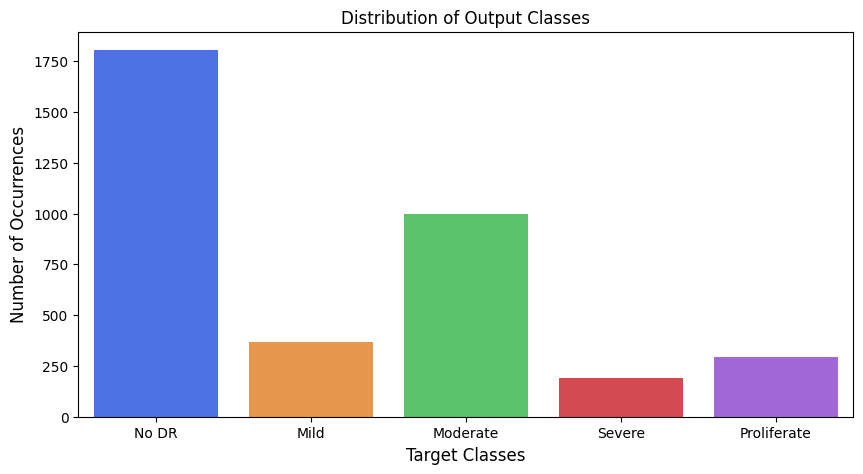

In [33]:
counts = train_csv['diagnosis'].value_counts()
class_list = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferate']
for i,x in enumerate(class_list):
    counts[x] = counts.pop(i)

plt.figure(figsize=(10,5))
sns.barplot(x=counts.index, y=counts.values, alpha=0.8, palette='bright')
plt.title('Distribution of Output Classes')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Target Classes', fontsize=12)
plt.show()

Visualising the training data

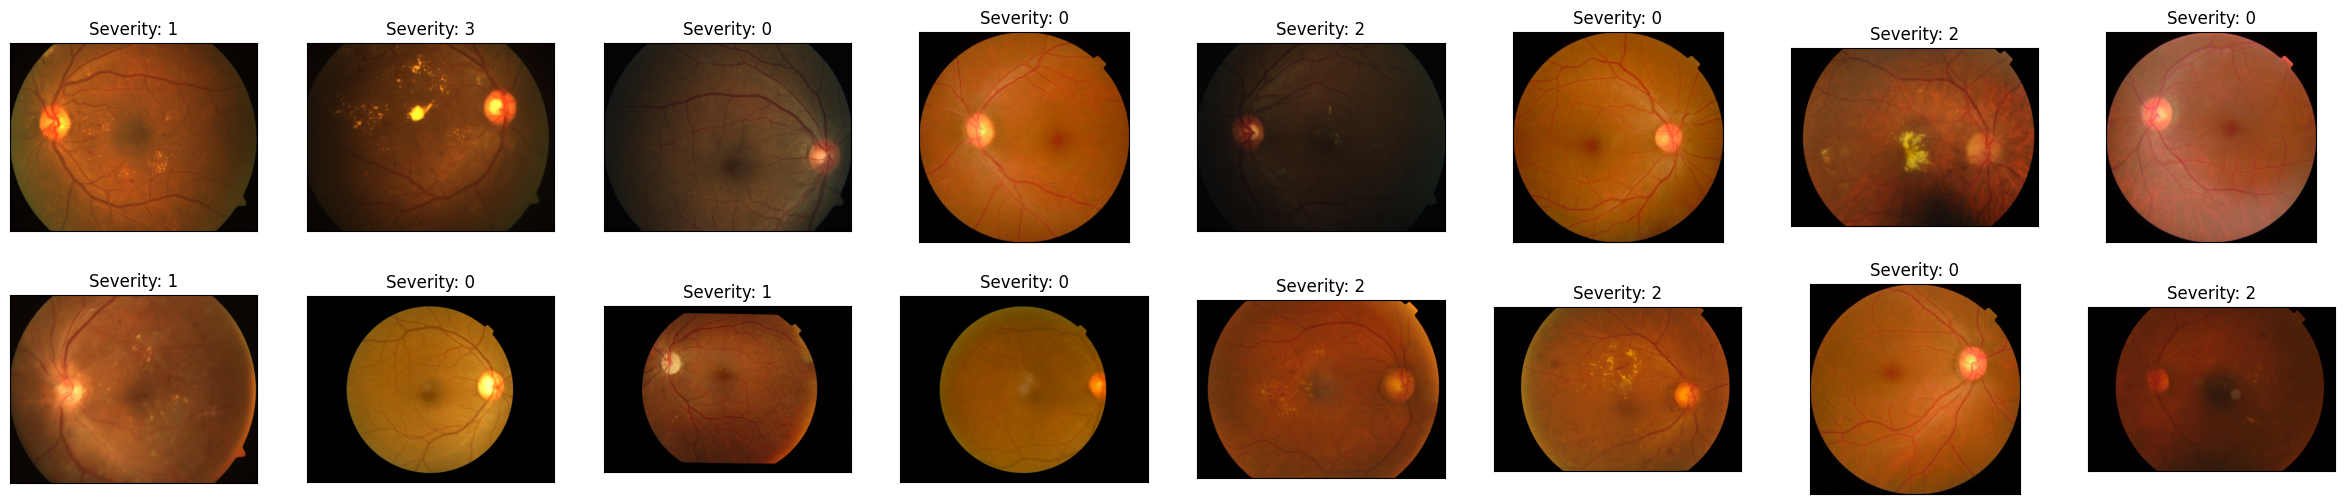

In [34]:
fig = plt.figure(figsize=(30, 6))
# display 20 images
train_imgs = os.listdir(base_dir+"/train_images")
for idx, img in enumerate(np.random.choice(train_imgs, 16)):
    ax = fig.add_subplot(2, 16//2, idx+1, xticks=[], yticks=[])
    im = Image.open(base_dir+"/train_images/" + img)
    plt.imshow(im)
    lab = train_csv.loc[train_csv['id_code'] == img.split('.')[0], 'diagnosis'].values[0]
    ax.set_title('Severity: %s'%lab)

Visualising Test data

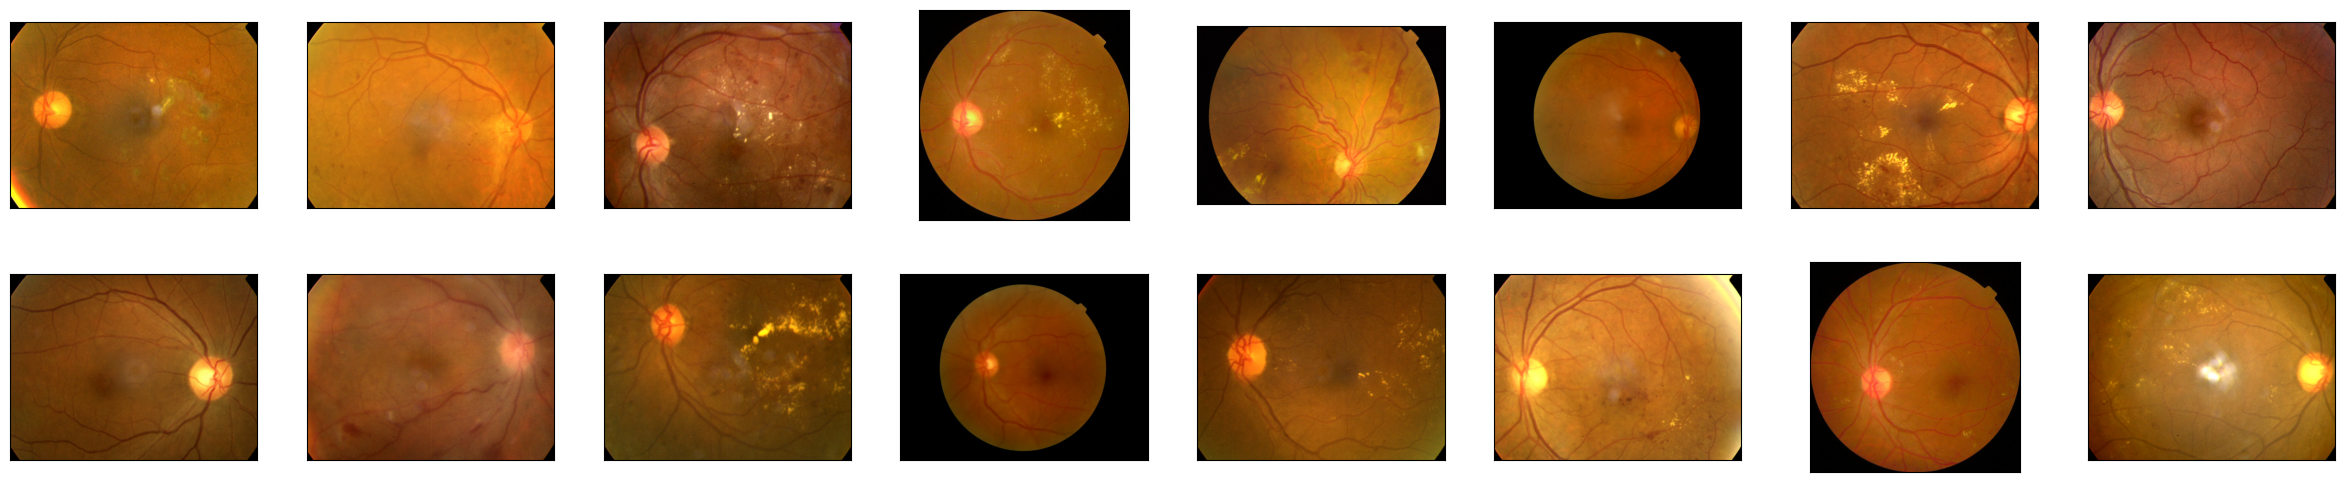

In [35]:
fig = plt.figure(figsize=(30, 6))
# display 20 images
test_imgs = os.listdir(base_dir+"/test_images")
for idx, img in enumerate(np.random.choice(test_imgs, 16)):
    ax = fig.add_subplot(2, 16//2, idx+1, xticks=[], yticks=[])
    im = Image.open(base_dir+"/test_images/" + img)
    plt.imshow(im)

Data Processing

In [36]:
class CreateDataset(Dataset):
    def __init__(self, df_data, data_dir = '../input/', transform=None):
        super().__init__()
        self.df = df_data.values
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_name,label = self.df[index]
        img_path = os.path.join(self.data_dir, img_name+'.png')
        image = cv2.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [37]:
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.4),
    #transforms.ColorJitter(brightness=2, contrast=2),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

In [38]:
test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

In [39]:
train_path = "../input/aptos2019-blindness-detection/train_images/"
test_path = "../input/aptos2019-blindness-detection/test_images/"

In [40]:
train_data = CreateDataset(df_data=train_csv, data_dir=train_path, transform=train_transforms)
test_data = CreateDataset(df_data=test_csv, data_dir=test_path, transform=test_transforms)

In [41]:
valid_size = 0.2
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

In [42]:
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [43]:
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64,sampler=train_sampler)
validloader = torch.utils.data.DataLoader(train_data, batch_size=64, sampler=valid_sampler)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)

In [44]:
print(f"training examples contain : {len(train_data)}")
print(f"testing examples contain : {len(test_data)}")

print(len(trainloader))
print(len(validloader))
print(len(testloader))

training examples contain : 3662
testing examples contain : 1928
46
12
31


In [45]:
# LOADING ONE BATCH OF TESTING SET TO CHECK THE IMAGES AND THEIR LABELS
images, labels = next(iter(trainloader))

# Checking shape of image
print(f"Image shape : {images.shape}")
print(f"Label shape : {labels.shape}")

# denormalizing images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

Image shape : torch.Size([64, 3, 224, 224])
Label shape : torch.Size([64])


labels: tensor([0, 2, 0, 0, 0, 2, 4, 0, 2, 1, 0, 0, 2, 4, 2, 0, 2, 2, 0, 3, 0, 2, 2, 1,
        3, 1, 0, 2, 0, 0, 4, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 1, 0, 4, 0,
        0, 2, 2, 2, 0, 0, 0, 2, 1, 4, 2, 1, 0, 0, 2, 2])


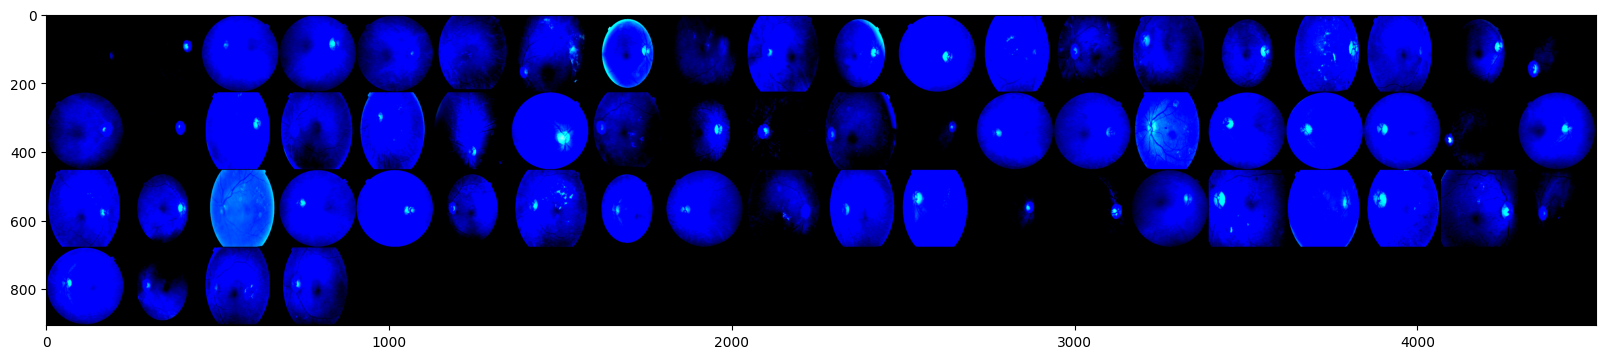

In [46]:
# plotting the images of loaded batch with given fig size and frame data    
import torchvision
import matplotlib.pyplot as plt
import numpy as np
grid = torchvision.utils.make_grid(images, nrow = 20, padding = 2)
plt.figure(figsize = (20, 20))  
plt.imshow(np.transpose(grid, (1, 2, 0)))   
print('labels:', labels)    

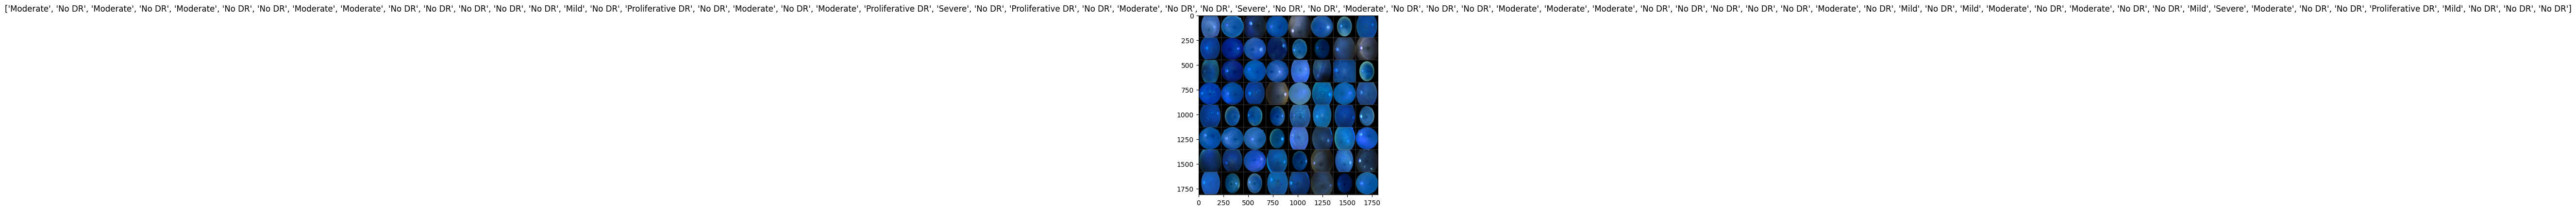

In [47]:
class_names = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR']

images, labels = next(iter(trainloader))
out = torchvision.utils.make_grid(images)
imshow(out, title=[class_names[x] for x in labels])

In [48]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalMaxPooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from torchvision.transforms import ToPILImage, Resize, ToTensor
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from PIL import Image

# Assuming  defined  trainloader, valloader, and testloader

#  resizing the input images and reorder dimensions
resize_transform = transforms.Compose([
    ToPILImage(),
    Resize((180, 180)),
    ToTensor(),
])

# Define the model
model = Sequential()
model.add(Conv2D(16, kernel_size=(3, 3), padding='same', input_shape=(180, 180, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(32, kernel_size=(3, 3), padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(5, activation='softmax'))

# Compile the model
optimizer = Adam()
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Training the model
num_epochs = 70

for epoch in range(70):
    for images, labels in trainloader:
        # Resize and reorder dimensions of the input images
        images_resized = torch.stack([resize_transform(img) for img in images])
        images_resized = images_resized.permute(0, 2, 3, 1)  # Change dimensions from (batch_size, channels, height, width) to (batch_size, height, width, channels)
        
        # Assuming  labels are in tensor format,  converting them to numpy and then to categorical
        labels = to_categorical(labels.numpy(), num_classes=5)
        
        # Training the model on the batch
        model.fit(images_resized.numpy(), labels, batch_size=64)  # Adjust batch size as needed
    
    # After each epoch, evaluating on the validation set
    #val_loss, val_acc = model.evaluate(validloader)
    # After each epoch, evaluating on the validation set
val_loss, val_acc = 0.0, 0.0
num_batches = len(validloader)

for images, labels in validloader:
    # Resize and reorder dimensions of the input images
    images_resized = torch.stack([resize_transform(img) for img in images])
    images_resized = images_resized.permute(0, 2, 3, 1)  # Change dimensions from (batch_size, channels, height, width) to (batch_size, height, width, channels)
    
    # Assuming labels are in tensor format, converting them to numpy and then to categorical
    labels = to_categorical(labels.numpy(), num_classes=5)
    
    # Calculate loss and accuracy for the batch
    batch_loss, batch_acc = model.evaluate(images_resized.numpy(), labels, verbose=0)
    val_loss += batch_loss
    val_acc += batch_acc

# Average loss and accuracy over all batches
val_loss /= num_batches
val_acc /= num_batches

print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss}, Validation Accuracy: {val_acc}')
    #print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss}, Validation Accuracy: {val_acc}')

# Save the model as a .h5 file
model.save('your_model.h5')


1/1 [==============================] - 1s 1s/step - loss: 0.2244 - accuracy: 0.9531
